# Continuous Action Control with Advantage Actor Critic

For a simple introduction to (Advantage) Actor Critic, I suggest you to look at this blog: https://huggingface.co/blog/deep-rl-a2c

In [4]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
# Function to render in notebook
def render_frame(env):
    frame = env.render()  # Returns the rendered frame as an RGB array
    plt.imshow(frame)
    plt.axis('off')  # Hide axis for better visualization
    clear_output(wait=True)  # Clear the previous frame
    plt.show()

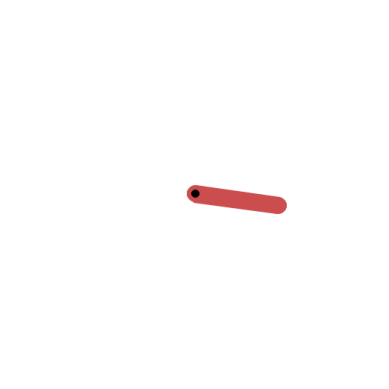

In [6]:
# Initialize the environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
state, info = env.reset()

render_frame(env)

### Goal 
- Apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

### Observation Space
- The observation is a ndarray with shape (3,) of continuous variables representing the x-y coordinates of the pendulum’s free end and its angular velocity.
    - x = cos(angle) [-1, 1]
    - y = sin(angle) [-1, 1]
    - z = theta, angular velocity [-8, 8]

### Action
- The torque applied to the end of the pendulum [-1, 1]

### Reward
- r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)
    - max is 0 when the pendulum is upright and no torque is applied

### End of episode
- After 200 timesteps

### Random Policy

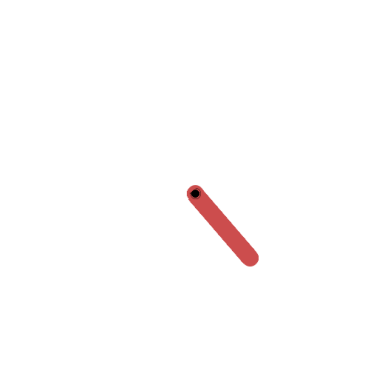

In [7]:
# visualize random policy

env = gym.make("Pendulum-v1", render_mode="rgb_array")
state, info = env.reset()

for _ in range(100):
    state, reward, done, _, info = env.step(env.action_space.sample())
    render_frame(env)

env.close()

In [8]:
env.observation_space, env.action_space

(Box([-1. -1. -8.], [1. 1. 8.], (3,), float32), Box(-2.0, 2.0, (1,), float32))

## Advantage based Actor Critic

The basic idea is to stabilize policy learning by computing the gradient in respect to an estimation of the long term returns given by a Critic function, instead of using the empirical (i.e. Monte Carlo) returns.

![policy_network](img/actor_critic.ppm)

### Actor Loss

We can stabilize learning further by using the Advantage function as Critic instead of the Action value function.

The idea is that the Advantage function calculates how better taking that action at a state is compared to the average value of the state. It’s subtracting the mean value of the state from the state action pair:

$A(s,a)=Q(s,a)-V(s)$

In other words, this function calculates the extra reward we get if we take this action at that state compared to the mean reward we get at that state.

The extra reward is what's beyond the expected value of that state.

- If $A(s,a)$ > 0: our gradient is pushed in that direction.
- If $A(s,a)$ < 0 (our action does worse than the average value of that state), our gradient is pushed in the opposite direction.


The problem with implementing this advantage function is that it requires two value functions $Q(s,a)$ and $V(s)$. Fortunately, we can use the TD error as a good estimator of the advantage function.

$A(s,a)=Q(s,a)-V(s)$

$Q(s,a)=r+\gamma*V(s')$

$A(s,a)=(r+\gamma*V(s'))-V(s)$

The actor loss therefore becomes:

$\mathcal{-log(\pi(a_t|s_t)A(s,a)=-log(\pi(a_t|s_t)A(s,a)(r+\gamma*V(s'))-V(s))$


![actor_loss](img/actor_loss.png)

### Critic Loss

The critic is trained using TD targets as we were doing for Q-Learing and DQN. However, here we train a Value fucntion in order to compute the advantages instead of the Q-Values themselves. 

![critic_loss](img/critic_loss.png)

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

class ActorNetwork(nn.Module):
    def __init__(self, obs_size, num_actions):
        super(ActorNetwork, self).__init__()
        
        self.layer1 = nn.Linear(obs_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.mu = nn.Linear(64, num_actions)
        self.std = nn.Linear(64, num_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        
        mu = torch.tanh(self.mu(x)) # tanh projects mu into -1, 1
        std = F.softplus(self.std(x)) + 1e-4 # small constant for numerical stability
        
        pi = Normal(mu, std)
        action = pi.sample()

        action = torch.clamp(action, -1, 1) # make sure is between -1 and 1 after sampling
        
        return action, pi


class CriticNetwork(nn.Module):
    def __init__(self, obs_size):
        super(CriticNetwork, self).__init__()
        
        self.layer1 = nn.Linear(obs_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.v = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        v = self.v(x)
        
        return v

In [119]:
actor = ActorNetwork(obs_size=3, num_actions=1)
action, pi = actor(torch.tensor(state))
action, pi

(tensor([-0.2356]),
 Normal(loc: tensor([0.0700], grad_fn=<TanhBackward0>), scale: tensor([0.6779], grad_fn=<AddBackward0>)))

In [120]:
critic = CriticNetwork(obs_size=3)
v = critic(torch.tensor(state))
v

tensor([0.0385], grad_fn=<ViewBackward0>)

In [153]:
def aac(env, gamma=0.9, lr_actor=0.00005, lr_critic=0.0005, num_episodes=1000, training_episodes=4):
    
    obs_size = env.observation_space.shape[0]
    actor = ActorNetwork(obs_size=obs_size, num_actions=1)
    actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)

    episode_returns = []
    for episode in range(1, num_episodes + 1):
        
        states  = [] # (n_episodes*timesteps)
        actions = [] # (n_episodes*timesteps)
        rewards = [] # (n_episodes*timesteps)
        new_states = [] # (n_episodes*timesteps)
        dones = [] # (n_episodes*timesteps)

        for n in range(training_episodes):
            
            # Collect episode
            state, info = env.reset()
            state_tensor = torch.tensor(state)
            done = False
            ep_rewards = []
            cum_reward = 0
            
            while not done:

                with torch.no_grad():

                    # get stochastic action (between -1 and 1)
                    action, pi = actor(state_tensor)

                    # project action into original action space (i.e., -2, 2)
                    env_action = action.numpy()*env.action_space.high.max() 
                    env_action = np.clip(env_action, env.action_space.low.min(), env.action_space.high.max()) # ensure is between -2 and 2

                    # step env
                    new_state, reward, done, truncated, _ = env.step(env_action)
                    done = done or truncated
                    if done: # avoid None tensors
                        new_state = state
                    new_state_tensor = torch.tensor(new_state)

                    # save transition
                    states.append(state_tensor)
                    actions.append(action)
                    rewards.append(float(reward))
                    new_states.append(new_state_tensor)
                    dones.append(int(done))

                    # update variables
                    state_tensor = new_state_tensor
                    cum_reward += reward
            
            episode_returns.append(cum_reward)


        # get tensors
        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.tensor(rewards)
        new_states = torch.stack(new_states)
        dones = torch.tensor(dones)

        # get advantages
        v = critic(states).squeeze()
        next_v = critic(new_states).squeeze()
        td_target = rewards + (1-dones)*gamma*next_v.detach() # detach to make sure don't pass the gradient over the target
        advantages = td_target - v
        advantages = advantages.detach() # the advantages are used in the actor loss, so detach make sure you don't pass the actor loss gradient to the critic
        
        # optimize actor
        _, pi = actor(states) # get pi of the states
        log_probs = pi.log_prob(actions).squeeze() # get log(pi(a|s))
        actor_loss = torch.mean(-log_probs * advantages.detach()) # -log(pi(a|s))*A(s,a)
        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(actor.parameters(), max_norm=0.5)
        actor_optimizer.step()

        # optimize critic
        critic_loss = F.mse_loss(td_target, v) # MSE of with TD target
        
        critic_optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
        critic_optimizer.step()

        # Log
        if episode % 100 == 0:
            print(f'Episode {episode}, actor loss: {actor_loss}, critic loss: {critic_loss} returns: {np.mean(episode_returns[-100:])}')

    return actor, critic, episode_returns

**Notice how training is more stable compared to Reinforce, but can still show instabilities. You might notice that the training fails some times. This depends heavily on the random initialization and the hyperparameters you're using.**

In [154]:
%%time
actor, critic, returns = aac(env, num_episodes=4000, training_episodes=3)

Episode 100, actor loss: -0.18873491883277893, critic loss: 13.820992469787598 returns: -1183.8882960428145
Episode 200, actor loss: -0.10430768132209778, critic loss: 17.138925552368164 returns: -1091.7890087842402
Episode 300, actor loss: -0.1484411060810089, critic loss: 13.90188980102539 returns: -1129.2378496639117
Episode 400, actor loss: 0.10002019256353378, critic loss: 18.513486862182617 returns: -1085.3693202504605
Episode 500, actor loss: -0.11015116423368454, critic loss: 13.21580982208252 returns: -1045.9155170341132
Episode 600, actor loss: -0.09647203981876373, critic loss: 8.480769157409668 returns: -1003.5087559583907
Episode 700, actor loss: -0.09925222396850586, critic loss: 6.841555118560791 returns: -988.9092171754698
Episode 800, actor loss: -0.21686133742332458, critic loss: 7.568208694458008 returns: -925.5554325385467
Episode 900, actor loss: -0.11402691900730133, critic loss: 9.700958251953125 returns: -867.3832981435489
Episode 1000, actor loss: -0.0800857916

Text(0, 0.5, 'Returns')

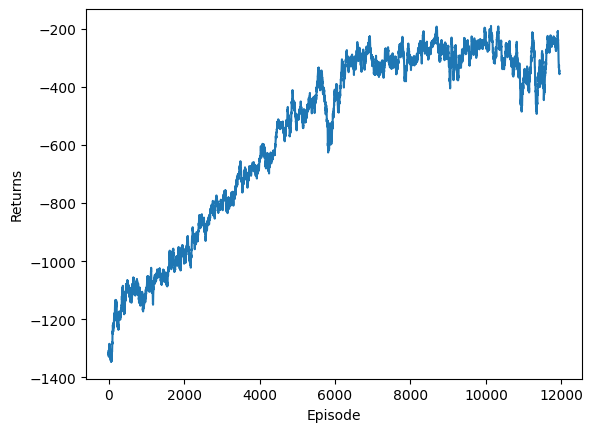

In [156]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(returns))
plt.xlabel('Episode')
plt.ylabel('Returns')

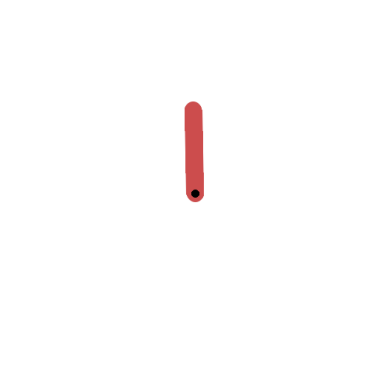

-260.7702517149492


In [161]:
state, info = env.reset()
render_frame(env)
done = False

r = 0
while not done:

    with torch.no_grad():
        action, _ = actor(torch.tensor(state))
        action = action*env.action_space.high.max() # project action into original action space (i.e., -2, 2)

    state, reward, done, truncated, _ = env.step(action.numpy())
    done = done or truncated
    render_frame(env)
    r += reward

print(r)